## Data Reduction

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import math
from IPython.display import display, HTML # This keeps the nice formatting when printing more than 1 thing

import matplotlib.pyplot as plt # Required for plotting
np.random.seed(33)

## Sampling in Pandas

In [2]:
df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))
df.head(5)

,A,B,C,D
0,-0.318854,-1.602981,-1.535218,-0.570401
1,-0.216728,0.254874,-0.149450,2.010783
2,-0.096784,0.422202,-0.225462,-0.637943
3,-0.016286,1.044217,-1.084880,-2.205925
4,-0.951219,0.832973,-1.000208,0.343463


In [3]:
#You can sample a fraction of the total dataframe
df.sample(frac=0.1,random_state=33)

,A,B,C,D
5,1.546030,0.690081,-2.045853,0.334467
27,-0.769156,0.869197,0.371381,-0.628362
37,-0.352427,0.274527,-1.386049,-1.775175
15,1.054113,-0.615562,0.437443,-2.809395
40,0.578353,-0.103730,-0.161044,0.894541


In [4]:
#Or a raw number
df.sample(n=7,random_state=33)

,A,B,C,D
5,1.546030,0.690081,-2.045853,0.334467
27,-0.769156,0.869197,0.371381,-0.628362
37,-0.352427,0.274527,-1.386049,-1.775175
15,1.054113,-0.615562,0.437443,-2.809395
40,0.578353,-0.103730,-0.161044,0.894541
45,0.000855,-0.146146,-0.261976,0.108848
4,-0.951219,0.832973,-1.000208,0.343463


In [5]:
#You can turn replacement on as well
df.sample(frac=0.3, replace=True)

,A,B,C,D
46,1.017882,-1.144546,0.781887,-0.173980
3,-0.016286,1.044217,-1.084880,-2.205925
22,0.604432,0.941819,-0.620143,0.814865
48,-0.637681,1.507013,-1.017813,-1.446111
39,0.346235,-0.449622,-1.355818,1.192042
9,-0.777376,-0.414635,-1.145641,0.325040
1,-0.216728,0.254874,-0.149450,2.010783
46,1.017882,-1.144546,0.781887,-0.173980
47,-0.341525,-1.879558,-0.993942,1.021854
8,1.734299,-0.206790,-0.733189,0.774163


## Stratified Sampling has it's own functions

In [6]:
from sklearn.cross_validation import StratifiedShuffleSplit

In [7]:
class_labels = []
for x in xrange(0,df.shape[0]):
    if x<20:
        class_labels.append(0)
    else:
        class_labels.append(1)
        
df['labels']= class_labels
display(df.head())
print('')
display(df.tail())

,A,B,C,D,labels
0,-0.318854,-1.602981,-1.535218,-0.570401,0
1,-0.216728,0.254874,-0.149450,2.010783,0
2,-0.096784,0.422202,-0.225462,-0.637943,0
3,-0.016286,1.044217,-1.084880,-2.205925,0
4,-0.951219,0.832973,-1.000208,0.343463,0


,A,B,C,D,labels
45,0.000855,-0.146146,-0.261976,0.108848,1
46,1.017882,-1.144546,0.781887,-0.173980,1
47,-0.341525,-1.879558,-0.993942,1.021854,1
48,-0.637681,1.507013,-1.017813,-1.446111,1
49,0.215798,-1.127582,0.439146,0.998467,1


In [8]:
sss = StratifiedShuffleSplit(df['labels'], 1, test_size=0.1, random_state=0)

for train_index, test_index in sss:
    population_remaining, population_sample = df.iloc[train_index], df.iloc[test_index]
    
population_sample

,A,B,C,D,labels
15,1.054113,-0.615562,0.437443,-2.809395,0
12,-0.682350,1.487670,-1.094711,-1.654707,0
43,0.594309,-0.166302,1.272612,2.076016,1
27,-0.769156,0.869197,0.371381,-0.628362,1
26,-0.587376,1.751572,0.308274,-0.894283,1


In [9]:
#Cluster Data Reduction
import time
from sklearn.cluster import DBSCAN
from sklearn import metrics

df = pd.read_csv('cluster_reduce.csv', encoding='utf-8')
df.head()

,lat,lon,date,city,country
0,51.481292,-0.451011,05/14/2014 09:07,West Drayton,United Kingdom
1,51.474005,-0.450999,05/14/2014 09:22,Hounslow,United Kingdom
2,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom
3,51.478199,-0.446081,05/14/2014 11:24,Hounslow,United Kingdom
4,51.474146,-0.451562,05/14/2014 11:38,Hounslow,United Kingdom


(1759, 5)


/afs/crc.nd.edu/user/k/kfeldman/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


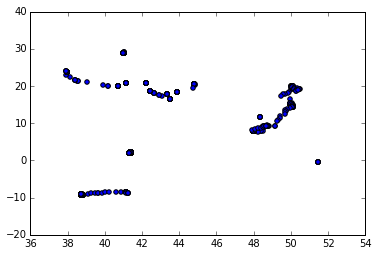

In [10]:
plt.scatter(df['lat'],df['lon'])
print(df.shape)

In [11]:
# represent points consistently as (lat, lon)
kms_per_radian = 6371.0088
coords = df.as_matrix(columns=['lat', 'lon'])
# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 1.5 / kms_per_radian

db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df))))

Clustered 1,759 points down to 138 clusters, for 92.2% compression


In [12]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [13]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [14]:
centermost_points = clusters.map(centeroidnp)
lats, lons = zip(*centermost_points)
# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

,lat,lon
133,37.933831,23.945850
134,40.979812,28.821654
135,41.032922,28.981427
136,41.016863,29.009547
137,48.356280,11.791802


(138, 2)


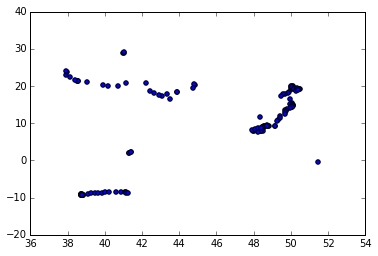

In [15]:
plt.scatter(rep_points['lat'],rep_points['lon'])
print(rep_points.shape)

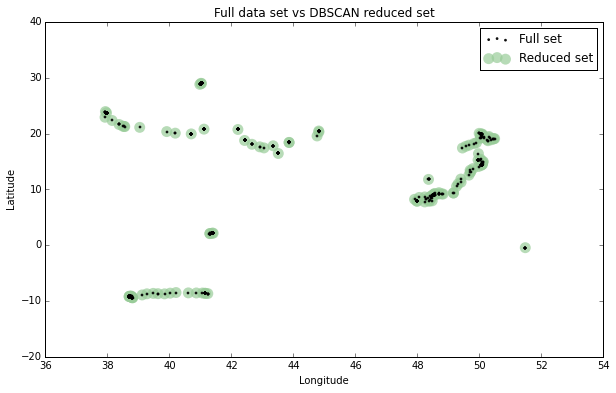

In [16]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rep_points['lat'],rep_points['lon'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['lat'], df['lon'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

## Feature Selection - Univariate

In [17]:
from sklearn.datasets import load_iris
fileURL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
data = pd.read_csv(fileURL, names=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Name'], header=None)
iris_data = data.dropna()
iris_data.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [18]:
X = iris_data[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']].copy()
y = iris_data[['Name']].copy()

#### These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile):  

For regression: *f_regression, mutual_info_regression*  
For classification: *chi2, f_classif, mutual_info_classif*  

The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

In [19]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
Selector_f = SelectKBest(chi2,k=1)
Selector_f.fit(X,y)
scores = []
for n,s in zip(['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'],Selector_f.scores_):
    scores.append((n,s))

scores = pd.DataFrame(scores)
scores.sort(1,ascending=False)

/afs/crc.nd.edu/user/k/kfeldman/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
2,Petal Length,116.169847
3,Petal Width,67.244828
0,Sepal Length,10.817821
1,Sepal Width,3.594499


In [20]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
selector.support_ 


selector.ranking_


array([1, 1, 1, 1, 1, 6, 4, 3, 2, 5])

In [21]:
#Extra - Feature Importances
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20, max_depth=4)
rfc = rf.fit(X,y)
print(rfc.feature_importances_)
scores = []
for n,s in zip(['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'],rfc.feature_importances_):
    scores.append((n,s))

scores = pd.DataFrame(scores)
scores.sort(1,ascending=False)

[ 0.09318801  0.15037965  0.06433626  0.1112646   0.05650729  0.10239585
  0.0834941   0.07682496  0.15486122  0.10674807]


,0,1
1,Sepal Width,0.150380
3,Petal Width,0.111265
0,Sepal Length,0.093188
2,Petal Length,0.064336


## PCA

For a full tutorial of PCA in python see the link below  
http://sebastianraschka.com/Articles/2014_pca_step_by_step.html

In [22]:
from sklearn.preprocessing import StandardScaler
fileURL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
data = pd.read_csv(fileURL, names=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Name'], header=None)
iris_data = data.dropna()
iris_data.head()

X = iris_data[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']].copy()
y = iris_data[['Name']].copy()

X_std = StandardScaler().fit_transform(X)
display(X.head())
pd.DataFrame(X_std).head()

,Sepal Length,Sepal Width,Petal Length,Petal Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


,0,1,2,3
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


In [23]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


In [24]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


In [25]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.93035377559
0.927403621517
0.148342226482
0.0207460139956


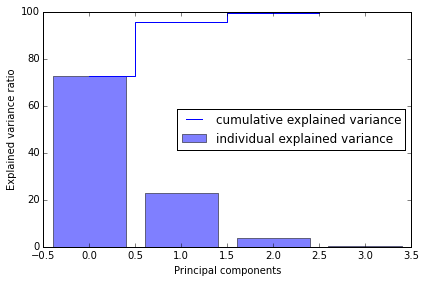

In [26]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize=(6, 4))

plt.bar(range(4), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(4), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:')
print(matrix_w)

Matrix W:
[[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


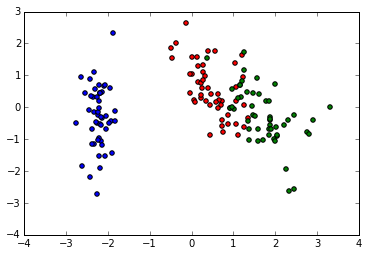

In [28]:
Y = X_std.dot(matrix_w)
Y = pd.DataFrame(Y)
plt.figure(figsize=(6, 4))
#plt.scatter(Y[0],Y[1],c=y)
for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                    ('blue', 'red', 'green')):
    plt.scatter(Y[Y.index.isin(y[y['Name']==lab].index)][0],
                Y[Y.index.isin(y[y['Name']==lab].index)][1],
                c=col)

In [29]:
existing_df = pd.read_csv('lecture5PCA.csv',index_col = 0, thousands  = ',')
existing_df.index.names = ['country']
existing_df.columns.names = ['year']
existing_df.head()

year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
country,,,,,,,,,,,,,,,,,,
Afghanistan,436,429,422,415,407,397,397,387,374,373,346,326,304,308,283,267,251,238
Albania,42,40,41,42,42,43,42,44,43,42,40,34,32,32,29,29,26,22
Algeria,45,44,44,43,43,42,43,44,45,46,48,49,50,51,52,53,55,56
American Samoa,42,14,4,18,17,22,0,25,12,8,8,6,5,6,9,11,9,5
Andorra,39,37,35,33,32,30,28,23,24,22,20,20,21,18,19,18,17,19


In [30]:
from sklearn.decomposition import RandomizedPCA
    
pca = RandomizedPCA(n_components=2)
pca.fit(existing_df)

RandomizedPCA(copy=True, iterated_power=3, n_components=2, random_state=None,
       whiten=False)

In [31]:
existing_2d = pca.transform(existing_df)
existing_df_2d = pd.DataFrame(existing_2d)
existing_df_2d.index = existing_df.index
existing_df_2d.columns = ['PC1','PC2']
existing_df_2d.head()

,PC1,PC2
country,,
Afghanistan,732.215864,203.381495
Albania,-613.296510,4.715978
Algeria,-569.303713,-36.837051
American Samoa,-717.082766,5.464696
Andorra,-661.802241,11.037736


In [32]:
print(pca.explained_variance_ratio_) 

[ 0.91808789  0.060556  ]


In [33]:
from sklearn.preprocessing import normalize
#We can scale the points by the countries mean value across the years, and can clearly see PCA seperate data based on the mean
    
existing_df_2d['country_mean'] = pd.Series(existing_df.mean(axis=1), index=existing_df_2d.index)
country_mean_max = existing_df_2d['country_mean'].max()
country_mean_min = existing_df_2d['country_mean'].min()
country_mean_scaled = (existing_df_2d.country_mean-country_mean_min) / country_mean_max
existing_df_2d['country_mean_scaled'] = pd.Series(
        country_mean_scaled, 
        index=existing_df_2d.index) 
existing_df_2d.head()

,PC1,PC2,country_mean,country_mean_scaled
country,,,,
Afghanistan,732.215864,203.381495,353.333333,0.329731
Albania,-613.296510,4.715978,36.944444,0.032420
Algeria,-569.303713,-36.837051,47.388889,0.042234
American Samoa,-717.082766,5.464696,12.277778,0.009240
Andorra,-661.802241,11.037736,25.277778,0.021457


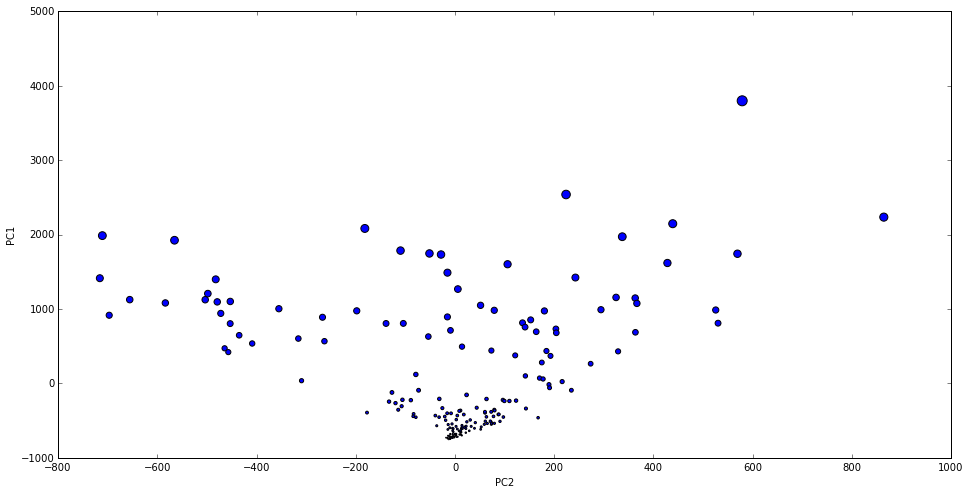

In [34]:
existing_df_2d.plot(
    kind='scatter', 
    x='PC2', 
    y='PC1', 
    s=existing_df_2d['country_mean_scaled']*100, 
    figsize=(16,8))

[  9.18087891e-01   6.05560009e-02   1.08051220e-02   2.39047545e-03
   2.19038229e-03   1.64732996e-03   1.19502740e-03   7.97856744e-04
   6.35817920e-04   4.61460559e-04   3.20989293e-04   2.66657191e-04
   2.42807240e-04   1.56998807e-04   1.08464204e-04   7.07768488e-05
   4.20518883e-05   2.38906112e-05]


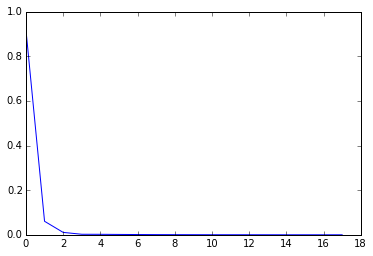

In [35]:
pca = RandomizedPCA()
pca.fit(existing_df)
print(pca.explained_variance_ratio_) 
plt.plot(pca.explained_variance_ratio_)